In [1]:
import os
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import anndata
from scipy.stats import spearmanr, pearsonr

from PIL import Image
import matplotlib
Image.MAX_IMAGE_PIXELS = None
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import sys
sys.path.append("../../")
from digitalhistopathology.benchmark.benchmark_clustering import BenchmarkClustering

2025-12-17 13:46:36.194795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software.9/software/code-server/4.93.1/lib:/software.9/software/code-server/4.93.1/lib
2025-12-17 13:46:36.194935: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software.9/software/code-server/4.93.1/lib:/software.9/software/code-server/4.93.1/lib
2025-12-17 13:46:36.194943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


/storage/homefs/ll25y867/.conda/envs/digitalhisto/lib/python3.10/site-packages/stlearn/tl/cci/het.py:206: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


# Unsupervised Clustering of HER2 dataset
This notebook contains the code to realize the plots of the unsupervised clustering of the HER2 dataset for the **retrained models**.

In [2]:
# Load configuration
with open("../../config/config_notebooks_HER2.json", "r") as config_file:
    config = json.load(config_file)

In [3]:
a = config["retrained_color_palette"]
sns.palplot(sns.color_palette(a))
extension='pdf'

In [4]:
# This will give you the results for the FULL models

model_type = config["retrained_model_list2_type"]
model_list = config["retrained_model_list2"]
benchmark_folder = config["retrained_benchmark_folder2"]
path_to_pipeline=config['path_to_retrained_pipelines_2']


# UNCOMMENT TO GENERATE THE RESULTS FOR THE EXPLORA MODELS
# model_type = config["retrained_model_list1_type"]
# model_list = config["retrained_model_list1"]
# benchmark_folder = config["retrained_benchmark_folder1"]
# path_to_pipeline=config['path_to_retrained_pipelines_1']

pairs_to_compare = [("uni", model) for model in model_list if model != "uni"]

models_palette = dict(zip(model_list, a))
models_palette["handcrafted_features"] = "lightgrey"

In [5]:
saving_folder=os.path.join(benchmark_folder, "unsupervised_clustering_ARI", "kmeans")

benchmark_clustering = BenchmarkClustering(path_to_pipeline=path_to_pipeline,
                                           pipelines_list=model_list,
                                           results_folder="../results",
                                           saving_folder=saving_folder,
                                           dataset=config['dataset'],
                                           extension=extension)

['uni', 'uni_full_kde_4096_prototypes', 'uni_full_kde_16384_prototypes', 'uni_full_kde_65536_prototypes', 'uni_full_koleo_4096_prototypes', 'uni_full_koleo_16384_prototypes', 'uni_full_koleo_65536_prototypes']
<class 'list'>
Label files: []


In [6]:
def plot_ari_scores_all_patients(clustering_dict, model_list=None):

    if model_list is None:
        model_list = clustering_dict.keys()

    ari_scores = {}
    for model in model_list:
        ari_scores[model] = {}
        for patient in clustering_dict[model].keys():
            if (patient != 'all') and (patient != 'mean'):
                ari_scores[model][patient] = clustering_dict[model][patient]['ari']
    df_aris = pd.DataFrame.from_dict(ari_scores)
    df_aris_melted = pd.melt(df_aris, var_name='model', value_name='ari')
    df_aris_melted['patient'] = df_aris.index.to_list()*len(df_aris.columns)

    sns.boxplot(data=df_aris_melted, x='model', y='ari', color='white', linewidth=2)
    sns.stripplot(data=df_aris_melted, x='model', y='ari', jitter=True, dodge=True, linewidth=1, hue='patient', palette='Accent')
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    plt.title('ARI scores for unsupervised clustering', weight='bold')

## Comparison between linear and unlinear clustering

In [7]:
try:
    with open(os.path.join(benchmark_folder, 'unsupervised_clustering_ARI', 'kmeans', 'unsupervised_clustering_results_optk.json')) as f:
        raw_clust = json.load(f)
except:
    raw_clust = benchmark_clustering.unsupervised_clustering_benchmark(n_clusters=None, clustering_name='raw')

try:
    with open(os.path.join(benchmark_folder, 'unsupervised_clustering_ARI', 'kmeans',  'svd5_multiplied_by_S_unsupervised_clustering_results_optk.json')) as f:
        svd_clust = json.load(f)
except:
    svd_clust = benchmark_clustering.unsupervised_clustering_benchmark(n_clusters=None, clustering_name='svd5')
    

try:
    with open(os.path.join(benchmark_folder, 'unsupervised_clustering_ARI', 'kmeans', 'best_umap_ari_per_slide.json')) as f:
        umap_clust = json.load(f)
except:
    umap_clust = benchmark_clustering.get_best_UMAP_ari_per_slide(force_loading=True)


In [8]:
for model in raw_clust.keys():
    print(f"Model: {model}: ari all: {raw_clust[model]['all']['ari']}, ari mean: {raw_clust[model]['mean']['ari']}")

Model: uni: ari all: 0.1405392782347744, ari mean: 0.2351268295263375
Model: uni_full_kde_4096_prototypes: ari all: 0.22435893962084028, ari mean: 0.19504631252412255
Model: uni_full_kde_16384_prototypes: ari all: 0.13403037034764706, ari mean: 0.19007796709910665
Model: uni_full_kde_65536_prototypes: ari all: 0.1009119945294695, ari mean: 0.16615053296027052
Model: uni_full_koleo_4096_prototypes: ari all: 0.246959512048176, ari mean: 0.1894203703846208
Model: uni_full_koleo_16384_prototypes: ari all: 0.1801047519580902, ari mean: 0.21054692645132875
Model: uni_full_koleo_65536_prototypes: ari all: 0.13071168730250624, ari mean: 0.18392541734273457
Model: handcrafted_features: ari all: 0.10094446204343024, ari mean: 0.11174721697791898


In [9]:
for model in raw_clust.keys():
    print(f"Model: {model}: ari tumor: {raw_clust[model]['ARI_tumor']}")

Model: uni: ari tumor: 0.14775572194802
Model: uni_full_kde_4096_prototypes: ari tumor: 0.18365074945187695
Model: uni_full_kde_16384_prototypes: ari tumor: 0.1890790502135067
Model: uni_full_kde_65536_prototypes: ari tumor: 0.1420053083676916
Model: uni_full_koleo_4096_prototypes: ari tumor: 0.17858172906558764
Model: uni_full_koleo_16384_prototypes: ari tumor: 0.18101867889344025
Model: uni_full_koleo_65536_prototypes: ari tumor: 0.13898538339225633
Model: handcrafted_features: ari tumor: 0.08584559722543653


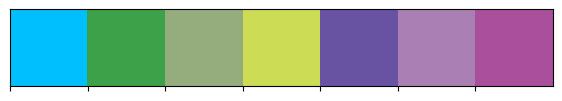

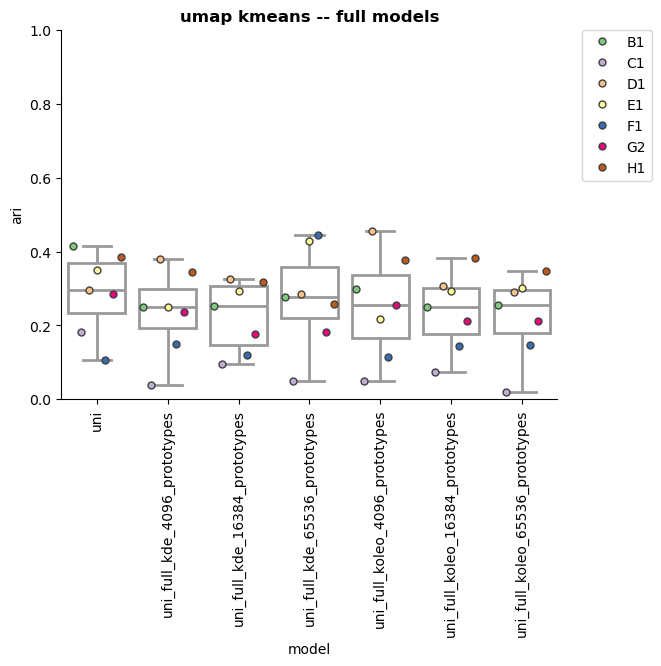

In [10]:
%matplotlib inline

plt.figure()
plot_ari_scores_all_patients(umap_clust, model_list=model_list)
plt.ylim(0, 1)
plt.title(f"umap kmeans -- {model_type} models", weight='bold')

if len(umap_clust[model_list[0]].keys()) > 15:
    plt.legend().remove()

In [11]:
dfs_clust = []
for clustering_dict, method in zip([raw_clust, svd_clust, umap_clust], ["raw", "svd", "umap"]):
    ari_scores = {}
    for model in clustering_dict.keys():
        ari_scores[model] = {}
        for patient in clustering_dict[model].keys():
            #if (patient != 'all') and (patient != 'mean'):
            if (patient != 'ARI_tumor'):
                ari_scores[model][patient] = clustering_dict[model][patient]['ari']
    df_aris = pd.DataFrame.from_dict(ari_scores)
    df_aris_melted = pd.melt(df_aris, var_name='model', value_name='ari')
    df_aris_melted['patient'] = df_aris.index.to_list()*len(df_aris.columns)
    df_aris_melted['clustering'] = method
    dfs_clust.append(df_aris_melted)

df_comp = pd.concat(dfs_clust)

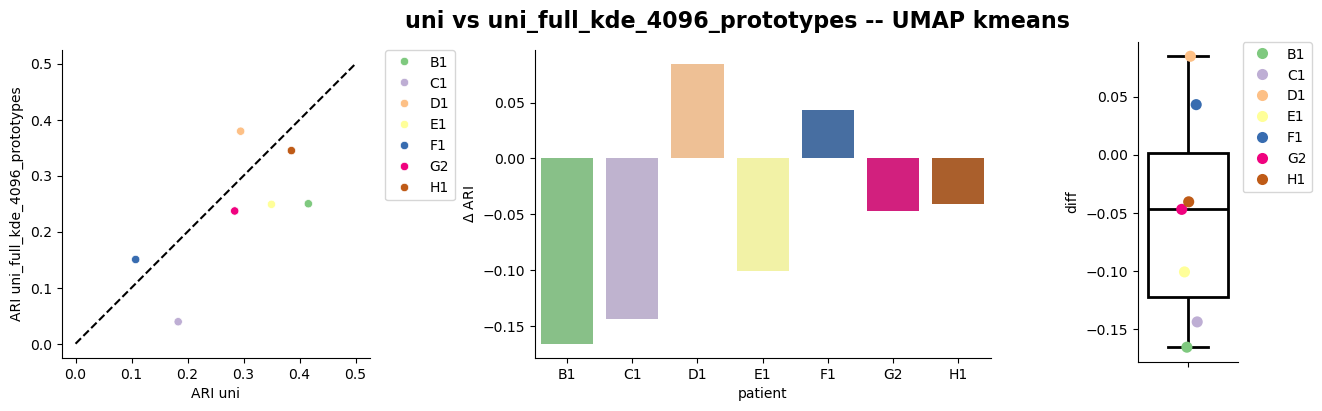

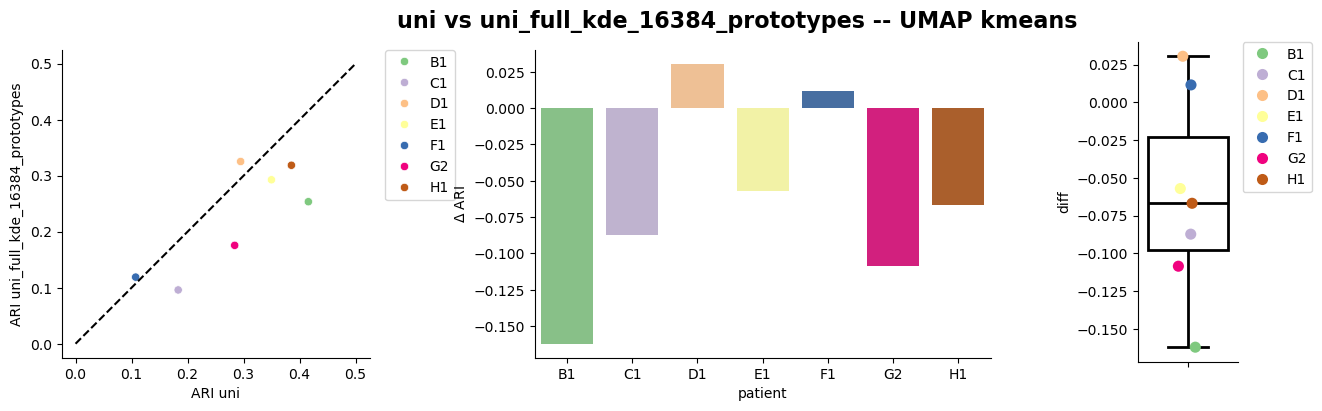

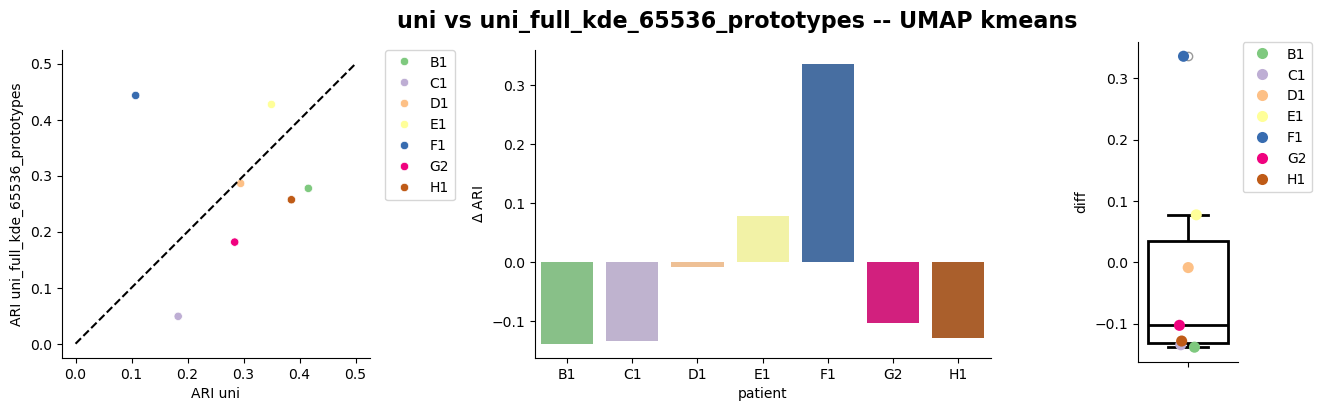

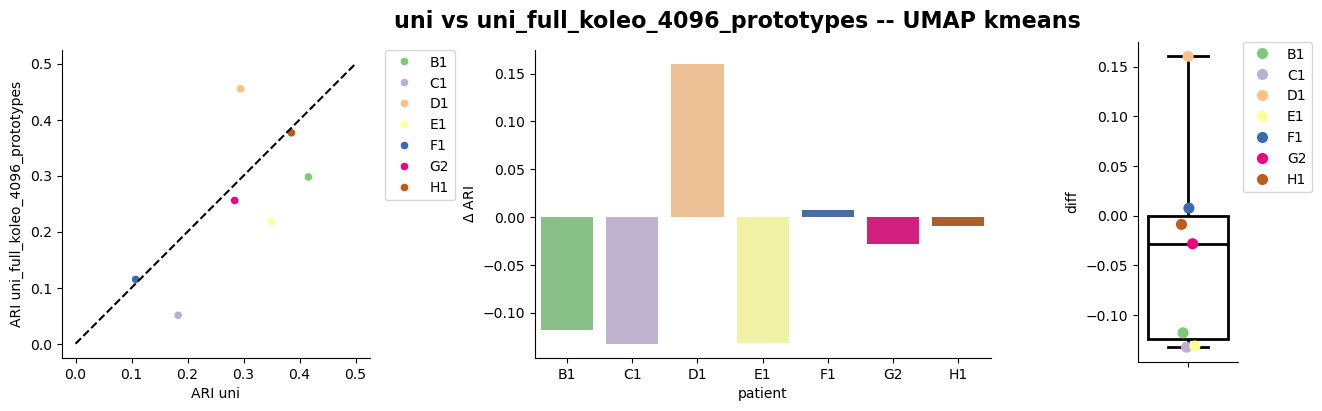

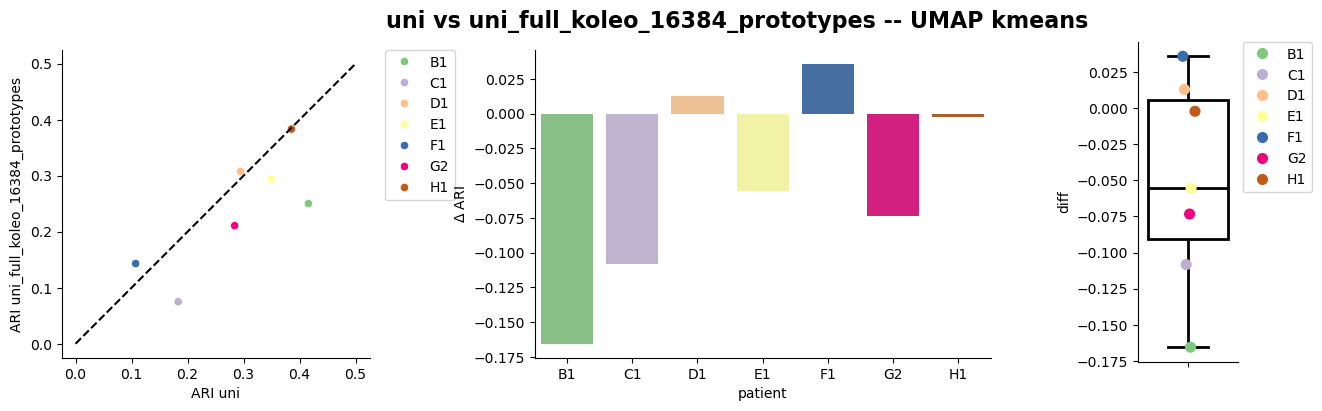

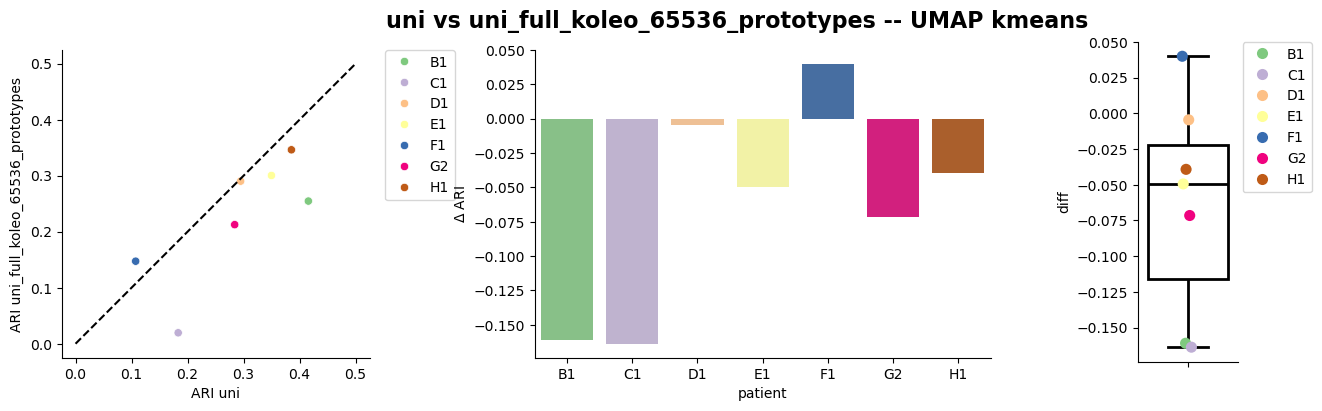

In [12]:
df_comps = {}

for clust_type in ['umap']:
  
  df_comps[clust_type] = {}
  for pair in pairs_to_compare:
    df_sub_comp = df_comp[
      (df_comp['model'] == pair[1]) & (df_comp['clustering'] == clust_type) 
      & (df_comp['patient'] != 'mean') & (df_comp['patient'] != 'all')
      ].merge(
        df_comp[(df_comp['model'] == pair[0]) & (df_comp['clustering'] == clust_type) 
        & (df_comp['patient'] != 'mean')  & (df_comp['patient'] != 'all')
        ], left_on='patient', right_on='patient', suffixes=(f'_{pair[1]}', f'_{pair[0]}'))
    
    df_comps[clust_type][f"{pair[1]}"] = df_sub_comp

    plt.figure(figsize=(20, 4))
    
    plt.subplot(1, 3, 1)    
    plt.gca().set_aspect('equal', adjustable='box')
    sns.scatterplot(data=df_sub_comp, x=f'ari_{pair[0]}', y=f'ari_{pair[1]}', hue='patient', palette='Accent')
    plt.plot([0, 0.5], [0, 0.5], color='black', linestyle='--')
    if len(df_sub_comp['patient'].unique()) > 15:
      plt.legend().remove()
    else:
      plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel(f'ARI {pair[0]}')
    plt.ylabel(f'ARI {pair[1]}')
    sns.despine()

    plt.subplot(1, 3, 2)
    df_sub_comp['diff'] = df_sub_comp[f'ari_{pair[1]}'] - df_sub_comp[f'ari_{pair[0]}']
    sns.barplot(x='patient', y='diff', data=df_sub_comp, palette='Accent', hue='patient') 
    sns.despine()
    plt.ylabel(r'$\Delta$ ARI')

    plt.subplot(1, 3, 3)
    plt.gca().set_position([0.7, 0.1, 0.05, 0.8])
    sns.boxplot(data=df_sub_comp, y='diff', color='white', linewidth=2,  boxprops=dict(facecolor='white', edgecolor='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='black'))
    sns.stripplot(data=df_sub_comp, y='diff', hue='patient', palette='Accent', linewidth=0, size=8)
    if len(df_sub_comp['patient'].unique()) > 15:
      plt.legend().remove()
    else:
      plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()

    plt.suptitle(f'{pair[0]} vs {pair[1]} -- {clust_type.upper()} kmeans', weight='bold', fontsize=16)
    plt.savefig(os.path.join(config["figures_folder"], f"Figure3/{pair[0]}_vs_{pair[1]}_{clust_type}_kmeans.pdf"), bbox_inches='tight')

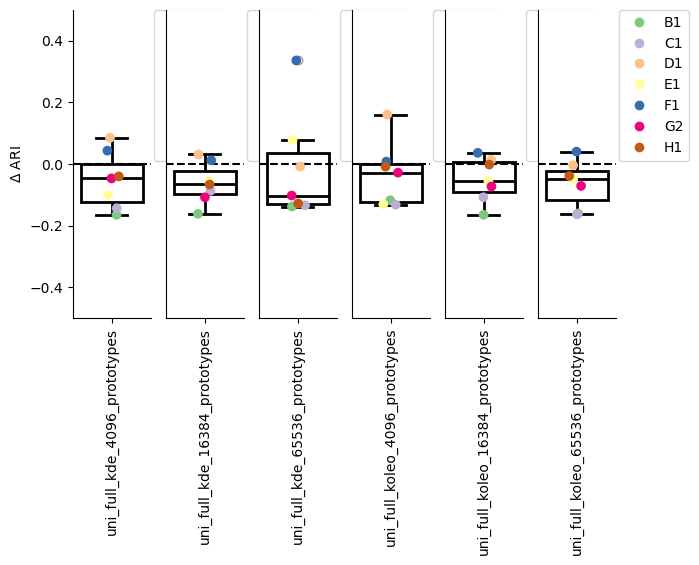

In [13]:
plt.figure(figsize=(7, 4))

for clust_type in ['umap']:
  for i, pair in enumerate(pairs_to_compare):
    df_comps[clust_type][f"{pair[1]}"]['diff'] = df_comps[clust_type][f"{pair[1]}"][f'ari_{pair[1]}'] - df_comps[clust_type][f"{pair[1]}"][f'ari_{pair[0]}']
    
    plt.subplot(1, len(pairs_to_compare), i+1)

    sns.boxplot(data=df_comps[clust_type][f"{pair[1]}"], y='diff', color='white', linewidth=2,  boxprops=dict(facecolor='white', edgecolor='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='black'))
    sns.stripplot(data=df_comps[clust_type][f"{pair[1]}"], y='diff', hue='patient', palette='Accent', linewidth=0, size=7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    plt.xticks(ticks=[0], labels=[pair[1]], rotation=90)
    plt.ylim(-0.5, 0.5)
    
    plt.axhline(0, color='black', linestyle='--')
    plt.ylabel(r'$\Delta$ ARI')
    if i != 0:
        plt.gca().axes.get_yaxis().set_visible(False)
    
    if i != len(pairs_to_compare) -1:
        plt.legend().remove()
        
    if len(df_comps[clust_type][f"{pair[1]}"]['patient'].unique()) > 15:
      plt.legend().remove()
    else:
      plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
plt.savefig(os.path.join(config["figures_folder"], f"Figure2/boxplot_ARI_differences_per_patient_{clust_type}_kmeans_{model_type}_models.pdf"), bbox_inches='tight')

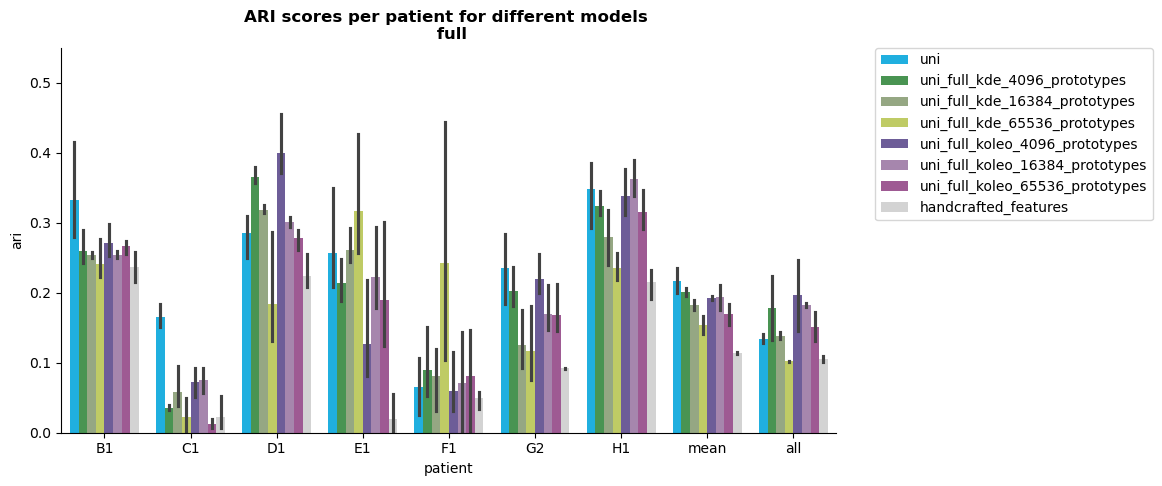

In [14]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_comp, x='patient', y='ari', hue='model', palette=models_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.title(f'ARI scores per patient for different models \n {model_type}', weight='bold')
plt.ylim(0, 0.55)
plt.show()

In [15]:
def make_spider(df, row, color, title):
    
    categories=list(df)[0:]
    N = len(categories)

    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]
     
    plt.rc('figure', figsize=(5, 5))
 
    ax = plt.subplot(1,1,1, polar=True)
 
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, color='black', size=12)
    ax.tick_params(axis='x', rotation=5.5)
    
    ax.set_rlabel_position(0)
    plt.yticks([0.1,0.2,0.3,0.4], ["0.1","0.2","0.3","0.4"], color="black", size=10)
    plt.ylim(0,0.55)
 
    values=df.reset_index().loc[row].values.tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color = color, alpha = 0.1)
 
  
    plt.title(title, fontsize=20, x = 0.5, y = 1.1)

In [16]:
df_comp_patient = df_comp[~(df_comp["patient"].isin(["mean", "all"]))]


In [17]:
df_comp[df_comp['clustering'] == 'raw'][['model', 'ari']].groupby('model').agg(['mean', 'std'])

ari          
                                     mean       std
model                                              
handcrafted_features             0.110547  0.087322
uni                              0.224617  0.094085
uni_full_kde_16384_prototypes    0.183850  0.094171
uni_full_kde_4096_prototypes     0.198303  0.106414
uni_full_kde_65536_prototypes    0.158902  0.075103
uni_full_koleo_16384_prototypes  0.207164  0.097864
uni_full_koleo_4096_prototypes   0.195814  0.114921
uni_full_koleo_65536_prototypes  0.178013  0.095711

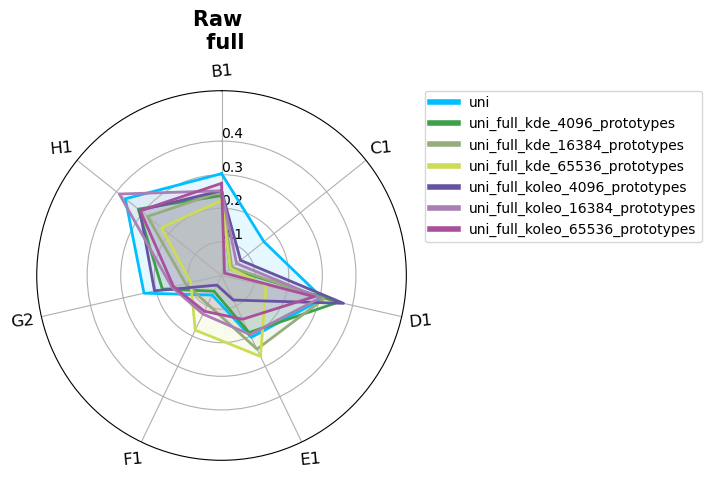

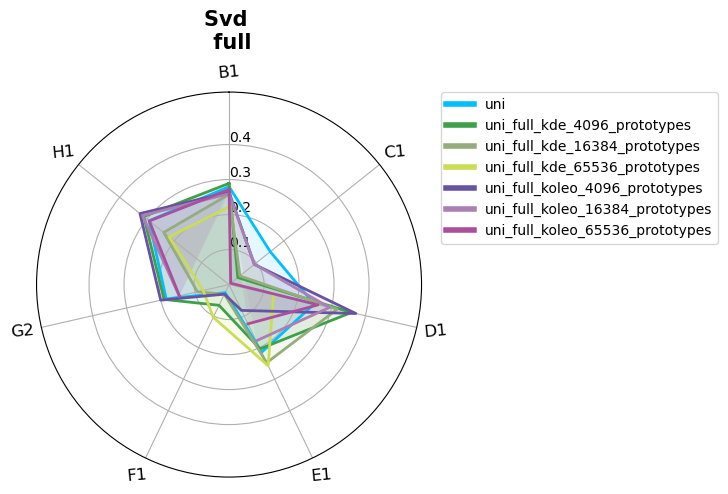

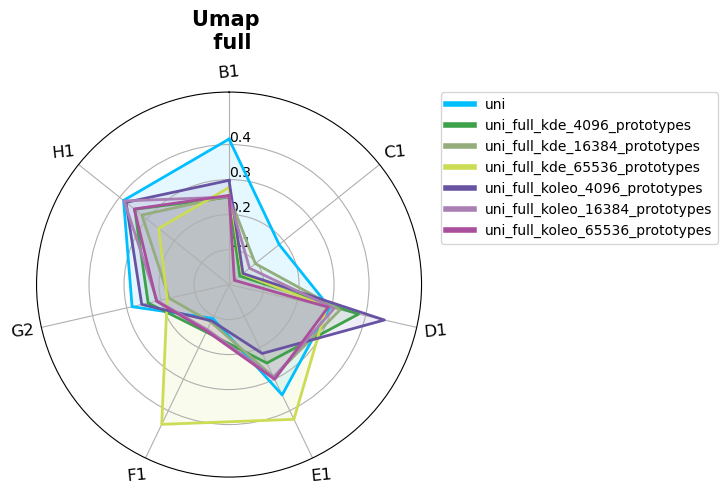

In [18]:
for clustering_technique in ['raw', 'svd', 'umap']:
    plt.figure()
    for i, model in enumerate(model_list):
        d_test = df_comp_patient[(df_comp_patient["model"] == model) & (df_comp_patient["clustering"] == clustering_technique)].T
        d_test.columns = d_test.loc['patient'].values
        make_spider(d_test, row=1, color=models_palette[model], title=model)
        plt.title(f"{clustering_technique.capitalize()} \n {model_type}", weight='bold', y=1.09, fontsize=15)

    handles = [plt.Line2D([0], [0], color=models_palette[model], lw=4) for model in model_list]
    plt.legend(handles, model_list, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.savefig(os.path.join(config["figures_folder"], f"Figure3/ari_scores_radar_plot_{clustering_technique}_{model_type}_models.pdf"), bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


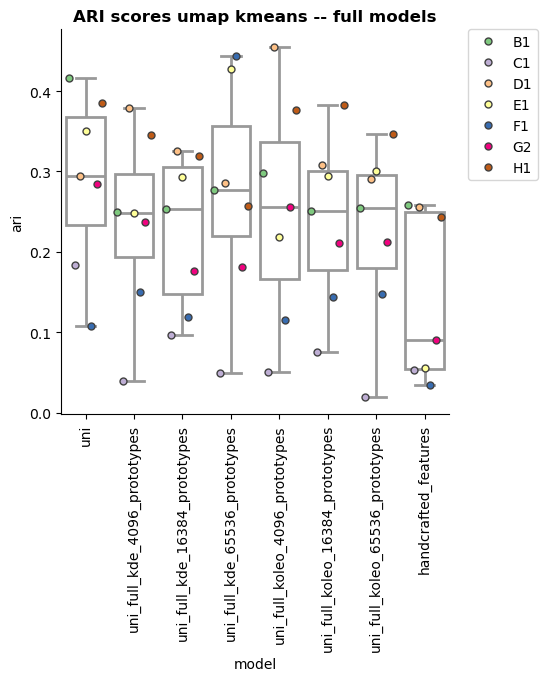

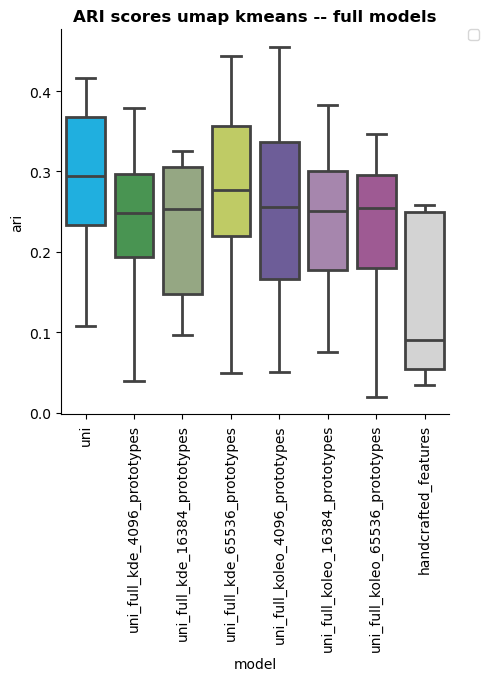

In [19]:
sns.boxplot(data=df_comp_patient[df_comp_patient['clustering'] == 'umap'], x='model', y='ari', color='white', linewidth=2)
sns.stripplot(data=df_comp_patient[df_comp_patient['clustering'] == 'umap'], x='model', y='ari', jitter=True, dodge=True, linewidth=1, hue='patient', palette='Accent')
plt.xticks(rotation=90)
sns.despine()
plt.title('ARI scores for unsupervised clustering', weight='bold')
sns.despine()
plt.title(f"ARI scores umap kmeans -- {model_type} models", weight='bold')

if len(df_comp_patient['patient'].unique()) > 15:
    plt.legend().remove()
else:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(config["figures_folder"], f"Figure2/ari_scores_umap_kmeans_{model_type}_models_with_patient.pdf"), bbox_inches='tight')


plt.figure()
sns.boxplot(data=df_comp_patient[df_comp_patient['clustering'] == 'umap'], 
            x='model', y='ari', hue='model', linewidth=2, palette=models_palette)
plt.xticks(rotation=90)
sns.despine()
plt.title('ARI scores for unsupervised clustering', weight='bold')
sns.despine()
plt.title(f"ARI scores umap kmeans -- {model_type} models", weight='bold')

if len(df_comp_patient['patient'].unique()) > 15:
    plt.legend().remove()
else:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/ari_scores_umap_kmeans_{model_type}_models_colors.pdf"), bbox_inches='tight')

In [20]:
for i, model in enumerate(df_comp['model'].unique()):
    sub_df = df_comp[(df_comp['model'] == model) & (df_comp['clustering'] == 'umap')][['ari', 'patient']].rename(columns = {'ari': model})
    if i > 0:
        df = df.merge(sub_df, on='patient')
    else:
        df = sub_df.copy()

df.set_index('patient', inplace=True)
df_delta_ari = df.apply(lambda x: x - df['uni'])
df_delta_ari.drop('uni', axis=1, inplace=True) 

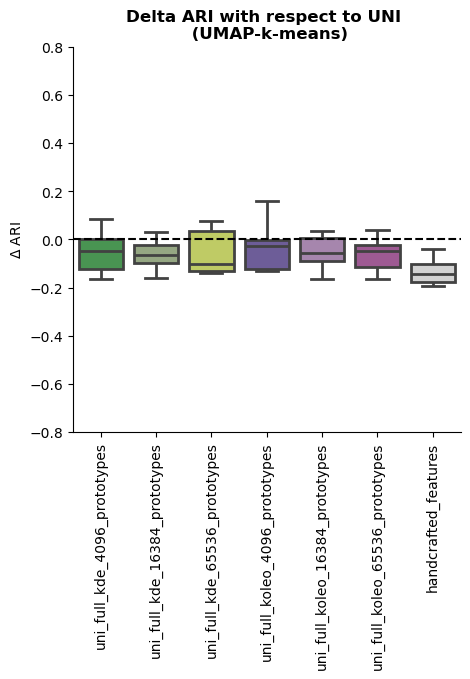

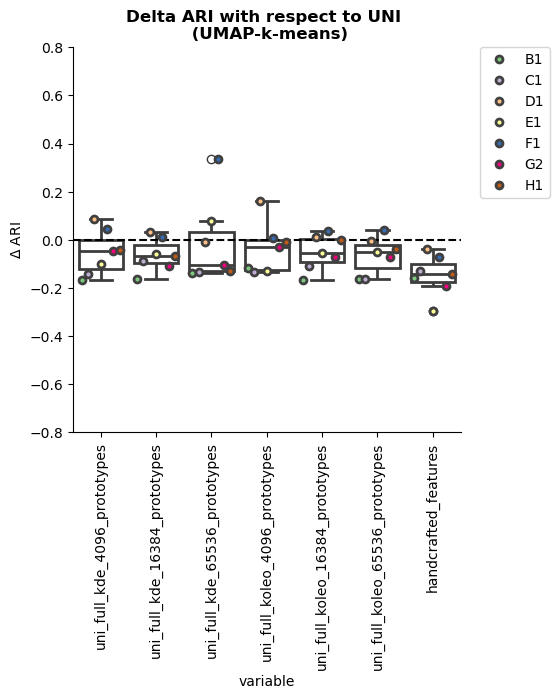

In [21]:
# Plot delta ARI
plt.figure()
sns.boxplot(data=df_delta_ari, palette=models_palette, linewidth=2, showfliers=False)
plt.title(f'Delta ARI with respect to UNI \n (UMAP-k-means)', weight='bold')
plt.ylabel(r'$\Delta$ ARI')
sns.despine()
plt.xticks(rotation=90)
plt.axhline(0, color='black', linestyle='--')
plt.savefig(os.path.join(config["figures_folder"], f"Figure2/delta_umap_ari_scores_boxplot_{model_type}_models_colors.pdf"), bbox_inches='tight')
plt.ylim(-0.8, 0.8)
plt.figure()
sns.boxplot(data=df_delta_ari, color='white', linewidth=2)
df_long = df_delta_ari.reset_index().melt(id_vars=['patient'], var_name='variable', value_name='value')

# Create the strip plot
sns.stripplot(data=df_long, x='variable', y='value', jitter=True, dodge=True, linewidth=2, palette='Accent', hue='patient')
plt.title(f'Delta ARI with respect to UNI \n (UMAP-k-means)', weight='bold')
plt.ylabel(r'$\Delta$ ARI')
sns.despine()
plt.xticks(rotation=90)
plt.axhline(0, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/delta_umap_ari_scores_boxplot_{model_type}_models_with_patient.pdf"), bbox_inches='tight')

if df_long['patient'].nunique() > 15:
    plt.legend().remove()
else:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.ylim(-0.8, 0.8)
plt.show()

In [22]:
# Correlation with shannon entropy
with open(os.path.join(benchmark_folder, "shannon_entropy", "shannon_entropy_all_comps_raw.json")) as f:
    shannon_entropy = json.load(f)

df_shannon = pd.DataFrame.from_dict(shannon_entropy, orient='index', columns=['shannon_entropy'])
df_shannon.rename(index={'handcrafted': 'handcrafted_features'}, inplace=True)

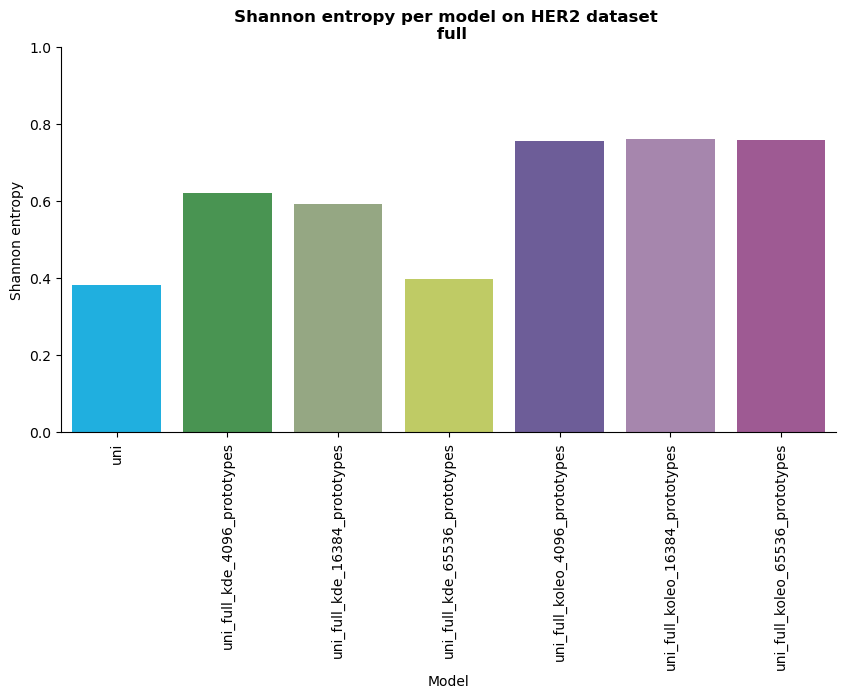

In [23]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_shannon, 
            x=df_shannon.index, 
            y='shannon_entropy', 
            hue=df_shannon.index, palette=models_palette)
sns.despine()
plt.xlabel("Model")
plt.ylabel("Shannon entropy")
plt.title(f"Shannon entropy per model on {config['dataset']} dataset \n {model_type}", weight='bold')
plt.xticks(rotation=90)
plt.ylim(0,1)
plt.savefig(os.path.join(config["figures_folder"], f"Figure2/shannon_entropy_per_model_{model_type}.pdf"), bbox_inches='tight')

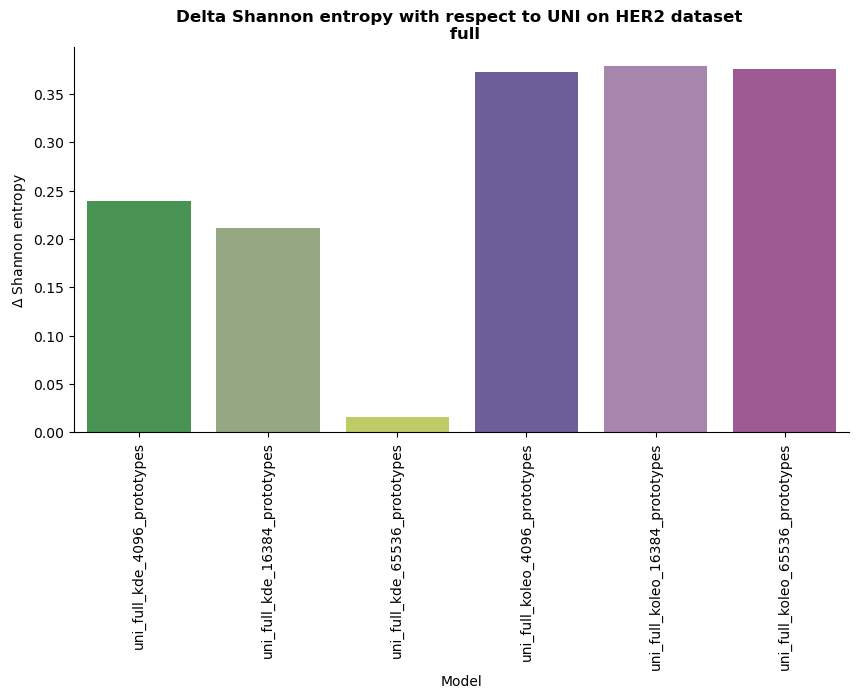

In [24]:
df_shannon_delta = df_shannon.copy()
df_shannon_delta = df_shannon_delta - df_shannon.loc['uni']
df_shannon_delta.drop('uni', inplace=True)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_shannon_delta, 
            x=df_shannon_delta.index, 
            y='shannon_entropy', 
            hue=df_shannon_delta.index, palette=models_palette)
sns.despine()
plt.xlabel("Model")
plt.ylabel(r"$\Delta$ Shannon entropy")
plt.title(f"Delta Shannon entropy with respect to UNI on {config['dataset']} dataset \n {model_type}", weight='bold')
plt.xticks(rotation=90)
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/delta_shannon_entropy_per_model_{model_type}_barplot.pdf"), bbox_inches='tight')





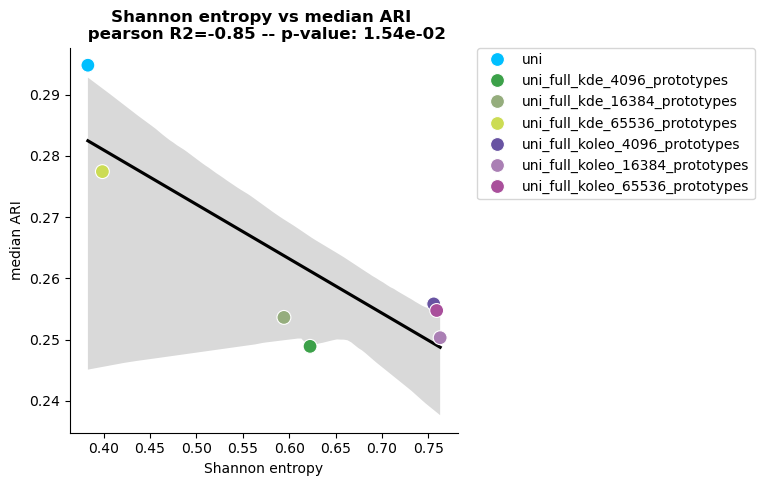

In [25]:
df_shannon = pd.DataFrame.from_dict(shannon_entropy, orient='index', columns=['shannon_entropy'])

median_ari_per_model = df_comp[df_comp['clustering'] == 'umap'][['model', 'ari']].groupby('model').median()
median_ari_per_model.columns = ['median_ari']

df_model_summary = df_shannon.merge(median_ari_per_model, left_index=True, right_index=True)

s, p = pearsonr(df_model_summary['shannon_entropy'], df_model_summary['median_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary, x='shannon_entropy', y='median_ari', color='black')
sns.scatterplot(data=df_model_summary, x='shannon_entropy', y='median_ari', hue=df_model_summary.index,
                palette=models_palette, zorder=2, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('median ARI')
plt.title(f'Shannon entropy vs median ARI \n pearson R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config["figures_folder"], f"Figure2/shannon_entropy_vs_median_ari_{model_type}_models.pdf"), bbox_inches='tight')

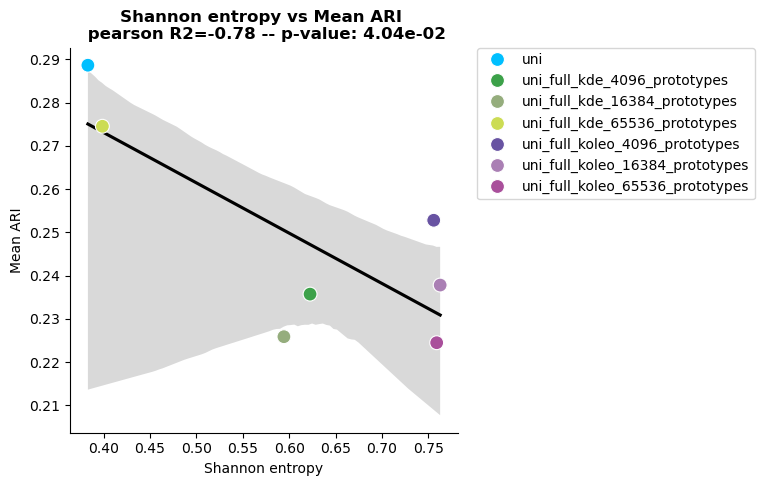

In [26]:
df_shannon = pd.DataFrame.from_dict(shannon_entropy, orient='index', columns=['shannon_entropy'])

mean_ari_per_model = df_comp[df_comp['clustering'] == 'umap'][['model', 'ari']].groupby('model').mean()
mean_ari_per_model.columns = ['mean_ari']

df_model_summary = df_shannon.merge(mean_ari_per_model, left_index=True, right_index=True)

s, p = pearsonr(df_model_summary['shannon_entropy'], df_model_summary['mean_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary, x='shannon_entropy', y='mean_ari', color='black')
sns.scatterplot(data=df_model_summary, x='shannon_entropy', y='mean_ari', hue=df_model_summary.index,
                palette=models_palette, zorder=2, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('Mean ARI')
plt.title(f'Shannon entropy vs Mean ARI \n pearson R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/shannon_entropy_vs_mean_ari_{model_type}_models.pdf"), bbox_inches='tight')

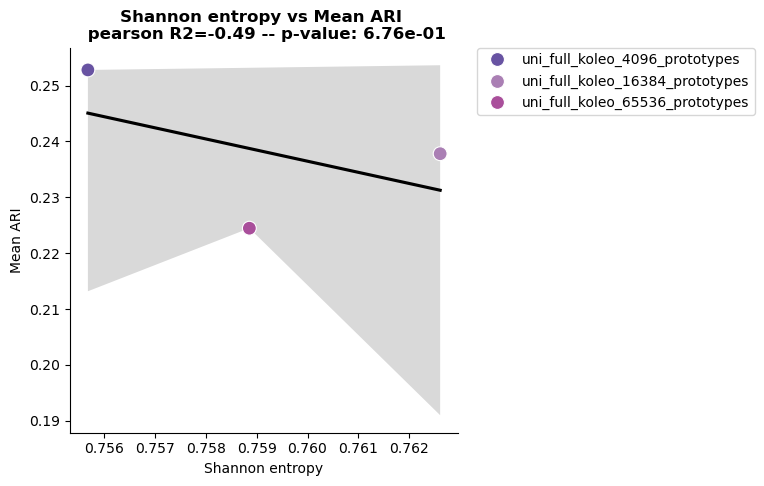

In [27]:
s, p = pearsonr(df_model_summary.loc[[idx for idx in df_model_summary.index if "koleo" in idx]]
['shannon_entropy'], df_model_summary.loc[[idx for idx in df_model_summary.index if "koleo" in idx]]
['mean_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary.loc[[idx for idx in df_model_summary.index if "koleo" in idx]]
, x='shannon_entropy', y='mean_ari', color='black')
sns.scatterplot(data=df_model_summary.loc[[idx for idx in df_model_summary.index if "koleo" in idx]]
, x='shannon_entropy', y='mean_ari', hue=df_model_summary.loc[[idx for idx in df_model_summary.index if "koleo" in idx]]
.index,
                palette=models_palette, zorder=2, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('Mean ARI')
plt.title(f'Shannon entropy vs Mean ARI \n pearson R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/shannon_entropy_vs_mean_ari_{model_type}_models.pdf"), bbox_inches='tight')

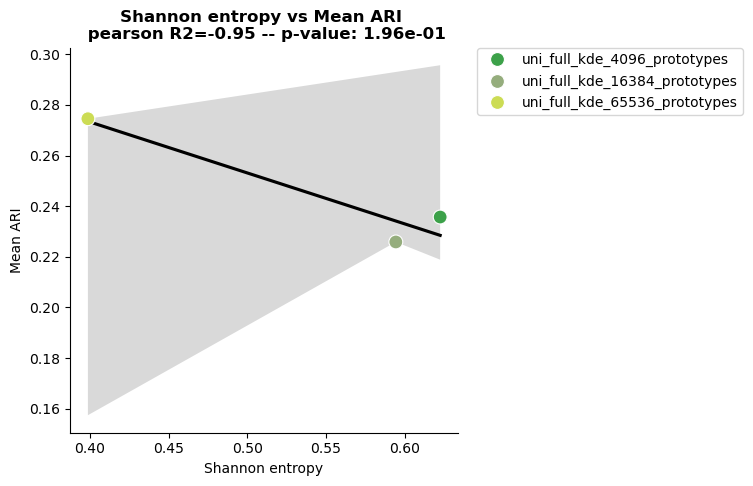

In [28]:
s, p = pearsonr(df_model_summary.loc[[idx for idx in df_model_summary.index if "kde" in idx]]
['shannon_entropy'], df_model_summary.loc[[idx for idx in df_model_summary.index if "kde" in idx]]
['mean_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary.loc[[idx for idx in df_model_summary.index if "kde" in idx]]
, x='shannon_entropy', y='mean_ari', color='black')
sns.scatterplot(data=df_model_summary.loc[[idx for idx in df_model_summary.index if "kde" in idx]]
, x='shannon_entropy', y='mean_ari', hue=df_model_summary.loc[[idx for idx in df_model_summary.index if "kde" in idx]]
.index,
                palette=models_palette, zorder=2, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('Mean ARI')
plt.title(f'Shannon entropy vs Mean ARI \n pearson R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/shannon_entropy_vs_mean_ari_{model_type}_models.pdf"), bbox_inches='tight')

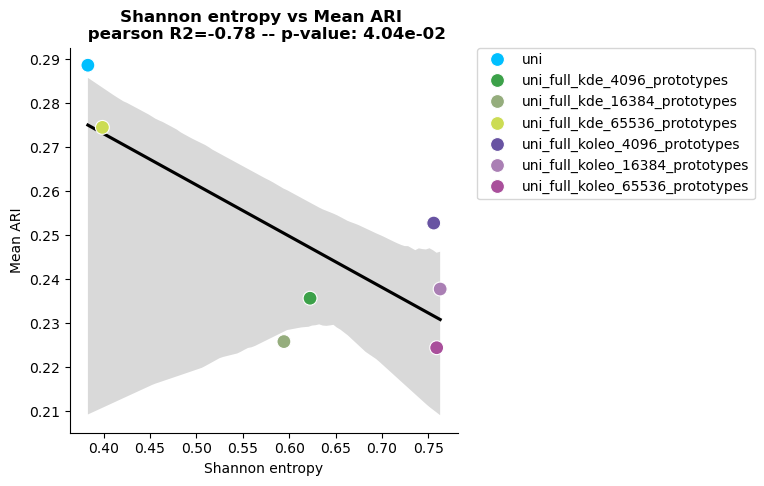

In [29]:

df_shannon = pd.DataFrame.from_dict(shannon_entropy, orient='index', columns=['shannon_entropy'])

mean_ari_per_model = df_comp[df_comp['clustering'] == 'umap'][['model', 'ari']].groupby('model').mean()
mean_ari_per_model.columns = ['mean_ari']

df_model_summary = df_shannon.merge(mean_ari_per_model, left_index=True, right_index=True)

s, p = pearsonr(df_model_summary['shannon_entropy'], df_model_summary['mean_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary, x='shannon_entropy', y='mean_ari', color='black')
sns.scatterplot(data=df_model_summary, x='shannon_entropy', y='mean_ari', hue=df_model_summary.index,
                palette=models_palette, zorder=2, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('Mean ARI')
plt.title(f'Shannon entropy vs Mean ARI \n pearson R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/shannon_entropy_vs_mean_ari_{model_type}_models.pdf"), bbox_inches='tight')

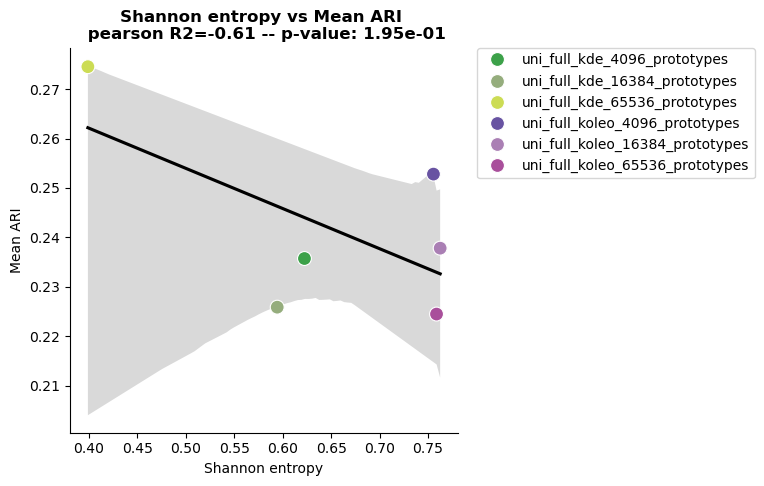

In [30]:
s, p = pearsonr(df_model_summary.drop("uni")['shannon_entropy'], df_model_summary.drop("uni")['mean_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary.drop("uni"), x='shannon_entropy', y='mean_ari', color='black')
sns.scatterplot(data=df_model_summary.drop("uni"), x='shannon_entropy', y='mean_ari', hue=df_model_summary.drop("uni").index,
                palette=models_palette, zorder=2, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('Mean ARI')
plt.title(f'Shannon entropy vs Mean ARI \n pearson R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()

In [31]:
try:
    with open(os.path.join(benchmark_folder, 'unsupervised_clustering_ARI', 'kmeans', "best_umap_ari_overall_annotated_only.json")) as f:
        overall_umap = json.load(f)
except:
    overall_umap = benchmark_clustering.get_best_UMAP_ari_overall()

overall_umap_aris = {}
for model in overall_umap.keys():
    overall_umap_aris[model] = overall_umap[model]['ari']

df_model_summary['overall_ari'] = pd.Series(overall_umap_aris)

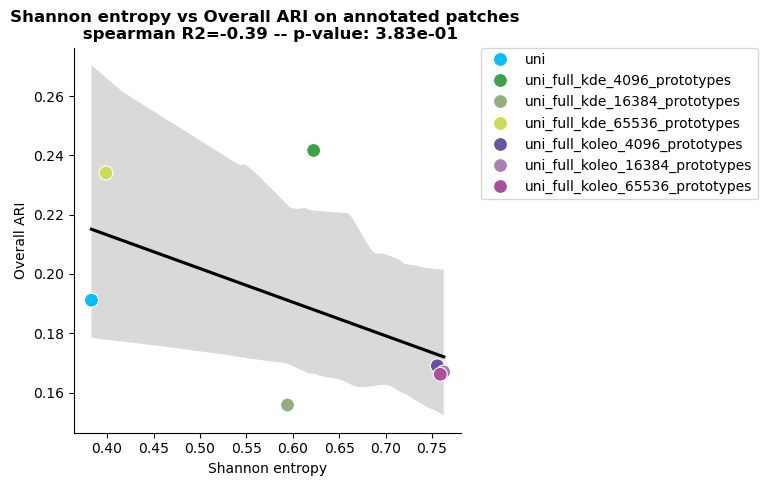

In [32]:
s, p = spearmanr(df_model_summary['shannon_entropy'], df_model_summary['overall_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary, x='shannon_entropy', y='overall_ari', color='black')
sns.scatterplot(data=df_model_summary, x='shannon_entropy', y='overall_ari', hue=df_model_summary.index,
                palette=models_palette, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('Overall ARI')
plt.title(f'Shannon entropy vs Overall ARI on annotated patches \n spearman R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config["figures_folder"], f"Figure2/shannon_entropy_vs_overall_ari_{model_type}_models.pdf"), bbox_inches='tight')

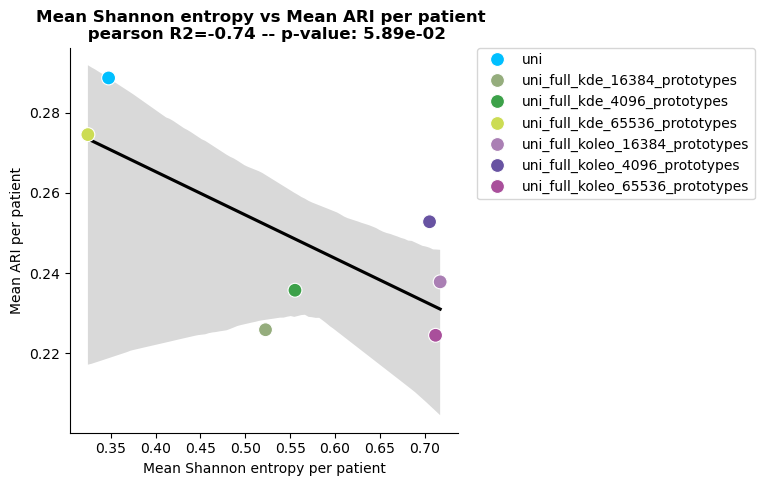

In [33]:
with open(os.path.join(benchmark_folder, "shannon_entropy", "shannon_entropy_per_group_all_comps_raw.json")) as f:
    shannon_per_patient = json.load(f)
    
df_shannon_per_patient = pd.DataFrame.from_dict(shannon_per_patient, orient='index')
df_shannon_per_patient

df_model_summary2 = df_comp[df_comp["clustering"] == 'umap'].merge(df_shannon_per_patient, left_on='patient', right_index=True, how='left')

df_shannon_per_patient_melted = pd.melt(df_shannon_per_patient, var_name='patient', value_name='shannon_entropy_per_patient')
df_shannon_per_patient_melted['model'] = list(df_shannon_per_patient.index) * len(df_shannon_per_patient.columns)

if config['dataset'] == 'HER2':
    df_comp['patient'] = df_comp['patient'].apply(lambda x: x[0])
else:
    df_comp['patient'] = df_comp['patient'].apply(lambda x: x.split('_')[0])

df_model_summary2 = df_comp[df_comp["clustering"] == 'umap'].merge(df_shannon_per_patient_melted, on=['patient', 'model'])

mean_vs_mean = df_model_summary2.groupby('model').mean(numeric_only=True)

s, p = pearsonr(mean_vs_mean['shannon_entropy_per_patient'], mean_vs_mean['ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=mean_vs_mean, x='shannon_entropy_per_patient', y='ari', color='black')
sns.scatterplot(data=mean_vs_mean, x='shannon_entropy_per_patient', y='ari', hue=mean_vs_mean.index,
                palette=models_palette, s=100, zorder=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Mean Shannon entropy per patient')
plt.ylabel('Mean ARI per patient')
plt.title(f'Mean Shannon entropy vs Mean ARI per patient \n pearson R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/mean_shannon_entropy_vs_mean_ari_{model_type}_models.pdf"), bbox_inches='tight')